In [3]:
# ===========================
# Imports
# ===========================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# XGBoost
import xgboost as xgb


In [4]:
# ===========================
# Load Dataset
# ===========================
df = pd.read_csv("nutrition_training_dataset_1200.csv")

In [5]:

print(df.head())
print(df.info())

         Barcode            Product_Name   Category  Sugar_g_per_100g  \
0  8908628574525  Bournvita Health Drink   Beverage              49.0   
1  8905805971677         Amul Toned Milk   Beverage              25.7   
2  8900052737759    ChocoBite Energy Bar      Snack               4.6   
3  8903257563556   Kellogg's Corn Flakes  Breakfast              14.5   
4  8904961432793    Paper Boat Aam Panna   Beverage              50.2   

   Fat_g_per_100g  Sodium_mg_per_100g  Protein_g_per_100g Additives  \
0             2.4                  85                13.5      E220   
1             2.6                  10                 1.2      E100   
2            19.9                 429                 2.2      E120   
3             9.9                 425                 4.5     E150d   
4             0.0                  10                 4.0      E330   

                                     Ingredient_Text Ingredient_Sentiment  \
0      salt, ragi, tamarind, coriander, preservative     

In [6]:

# ===========================
# Features & Target
# ===========================
features = df[['Sugar_g_per_100g', 'Fat_g_per_100g', 'Sodium_mg_per_100g', 'Protein_g_per_100g']]
target = df['Health_Label']

In [7]:
# Label Encoding
le = LabelEncoder()
target_enc = le.fit_transform(target)

In [8]:

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("Saved label encoder ✅")

Saved label encoder ✅


In [9]:

# ===========================
# Train-Test Split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    features, target_enc, test_size=0.2, random_state=42, stratify=target_enc
)



In [10]:

# ===========================
# Model Definitions (Optimized)
# ===========================

models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=6, criterion='entropy'),
    "Naive Bayes": GaussianNB(),
    
    # Scaled models use pipelines
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(gamma='scale', probability=True))
    ]),

    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=300))
    ]),

    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=7))
    ]),

    # Tuned Random Forest
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ),

    # Tuned XGBoost
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="mlogloss",
        random_state=42
    )
}


In [11]:

# ===========================
# Train + Evaluate All Models
# ===========================
accuracies = {}
trained_models = {}

for name, model in models.items():
    print("\n====================")
    print(f" Training: {name}")
    print("====================")



 Training: Decision Tree

 Training: Naive Bayes

 Training: SVM

 Training: Logistic Regression

 Training: KNN

 Training: Random Forest

 Training: XGBoost


In [12]:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    trained_models[name] = model

    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.8958
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        43
           1       0.88      0.85      0.86        94
           2       0.92      0.94      0.93       103

    accuracy                           0.90       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.90      0.90      0.90       240



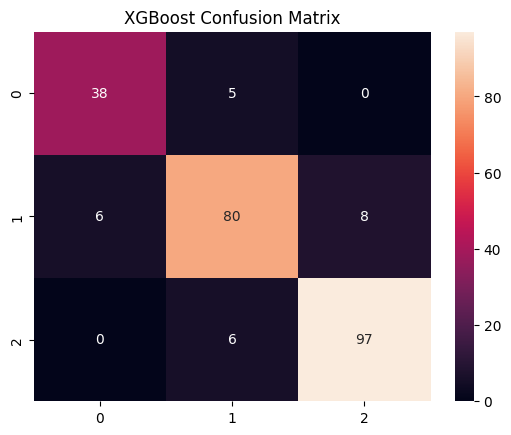

In [13]:

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [14]:
# ===========================
# Pick Best Model Automatically
# ===========================
best_model_name = max(accuracies, key=accuracies.get)
best_model = trained_models[best_model_name]

print("\n✅ BEST MODEL:", best_model_name)
print("✅ Accuracy:", accuracies[best_model_name])



✅ BEST MODEL: XGBoost
✅ Accuracy: 0.8958333333333334


In [15]:
# ===========================
# Save the Best Model
# ===========================
with open("nutrition_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

joblib.dump({
    "model": best_model,
    "label_encoder": le,
    "feature_order": list(features.columns)
}, "nutrition_bundle.joblib")

print("\n✅ Saved best model → nutrition_best_model.pkl")
print("✅ Saved deployment bundle → nutrition_bundle.joblib")


✅ Saved best model → nutrition_best_model.pkl
✅ Saved deployment bundle → nutrition_bundle.joblib


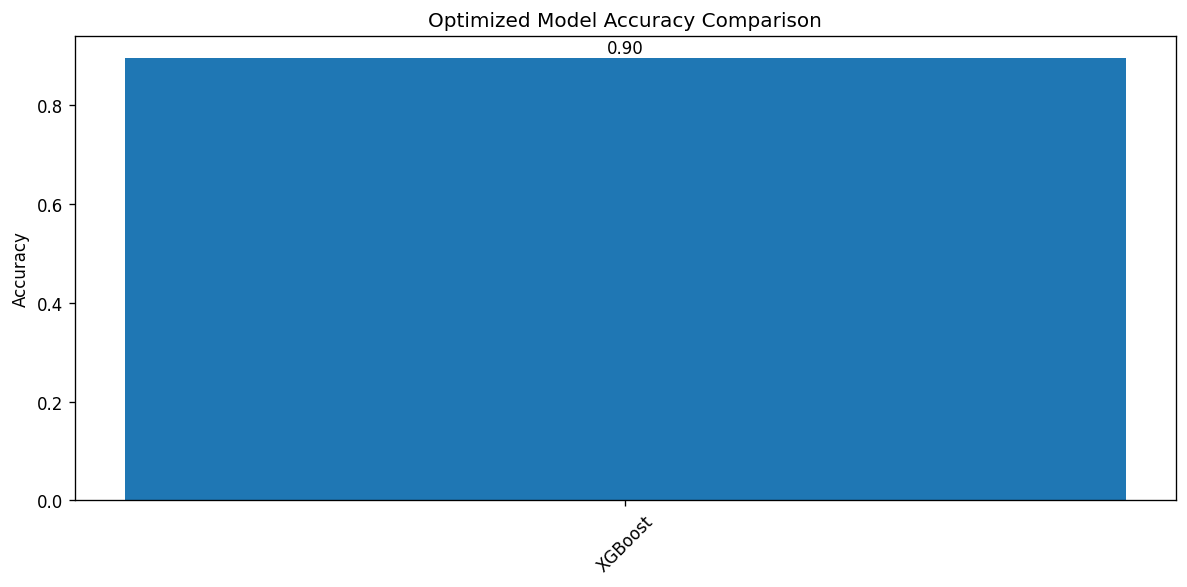

In [16]:
# ===========================
# Accuracy Comparison Plot (Improved)
# ===========================
plt.figure(figsize=(10, 5), dpi=120)

# Sort models by accuracy (best first)
sorted_acc = dict(sorted(accuracies.items(), key=lambda x: x[1], reverse=True))

plt.bar(sorted_acc.keys(), sorted_acc.values())

# Add accuracy values above bars
for idx, value in enumerate(sorted_acc.values()):
    plt.text(idx, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Optimized Model Accuracy Comparison")
plt.tight_layout()
plt.show()
